In [1]:
import pandas as pd
import numpy as np
from biom import load_table
from skbio.stats.ordination import ca, pcoa
from skbio import DistanceMatrix
import matplotlib.pyplot as plt
import scipy
from gneiss.util import match
from functools import partial
%matplotlib inline

In [2]:
soils88_table = load_table('../data/238_otu_table.biom')
soils88_mapping = pd.read_table('../data/103_prep_568_qiime_20150818-225427.txt', index_col=0)

emp_subtable = load_table('../data/pst_table.biom')
emp_submapping = pd.read_table('../data/pst_mapping.txt', index_col=0)

In [3]:
def convert_biom_to_pandas(table):
    """ Unpacks biom table into two pandas dataframes.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    otu_table : pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    taxonomy : pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """
    otu_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    otu_ids = table.ids(axis='observation')
    
    mapping = {}
    fillers = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    for id_ in otu_ids:        
        taxa = table.metadata(id=id_, axis='observation')['taxonomy']
        xtra = len(fillers) - len(taxa)
        if xtra > 0:
            mapping[id_] = taxa + fillers[-xtra:]
        else:
            mapping[id_] = taxa
        
    #mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in otu_ids}
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species']).T
    return otu_table, taxonomy


In [4]:
soils88_table, soils88_taxonomy = convert_biom_to_pandas(soils88_table)
emp_subtable, emp_taxonomy = convert_biom_to_pandas(emp_subtable)

In [9]:
soils88_table, soils88_mapping = match(soils88_table, soils88_mapping)
emp_subtable, emp_submapping = match(emp_subtable, emp_submapping)

In [10]:
soils88_euclidean_dm = DistanceMatrix.from_iterable(soils88_table.values, metric=scipy.spatial.distance.euclidean)
soils88_euclidean_dm.ids = soils88_table.index
soils88_euclidean_pc = pcoa(soils88_euclidean_dm)

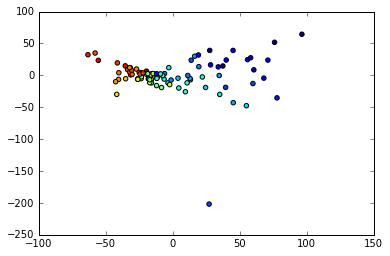

In [15]:
plt.scatter(soils88_euclidean_pc.samples.PC1, soils88_euclidean_pc.samples.PC2, c=soils88_mapping.ph)